##### 1) State the different modeling approaches that you will compare to address the business opportunity.

1. Autoregressive moving average integrated models (ARIMA)

2. Facebook's Prophet time-series forecasting model

###### Importing libraries

In [1]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
%matplotlib inline

In [2]:
from data_ingestor import *
from time_series import *

##### Defining variables to be used

In [3]:
path_to_json = "/Users/shivamsolanki/Desktop/Study/AI_workflow_coursera/ai-workflow-capstone/cs-train/"
column_dict ={'country': 'country', 'customer_id': 'customer_id',
                       'day': 'day','invoice': 'invoice', 'month': 'month',
                       'total_price': 'price', 'StreamID': 'stream_id',
                        'TimesViewed': 'times_viewed'}
inconsistent_col = ['TimesViewed', 'StreamID', 'total_price']
keys=['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']

##### Using module to read the file and carry out pre-processing

In [4]:
df_total = read_all_json_files(path_to_json, column_dict, inconsistent_col, keys)
df_clean = maintain_datatype(df_total)
df_clean = drop_non_numeric_invoice(df_clean)
df_day = df_clean.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day = create_date_col(df_day)
df_day.head()

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




(815011, 9)


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,times_viewed,price,country,Date
0,2017,11,28,14841,13979.67,United Kingdom,2017-11-28
1,2017,11,29,14121,13201.65,United Kingdom,2017-11-29
2,2017,11,30,15673,11145.50,United Kingdom,2017-11-30
3,2017,12,1,12461,9512.81,United Kingdom,2017-12-01
4,2017,12,2,3313,1443.26,United Kingdom,2017-12-02


In [5]:
# Removing outliers: price>20,000
print(df_day.shape)
df_day = df_day[df_day['price']<=20000]
df_day.shape

(495, 7)


(485, 7)

#### 2) Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.

#### Plotting time-series

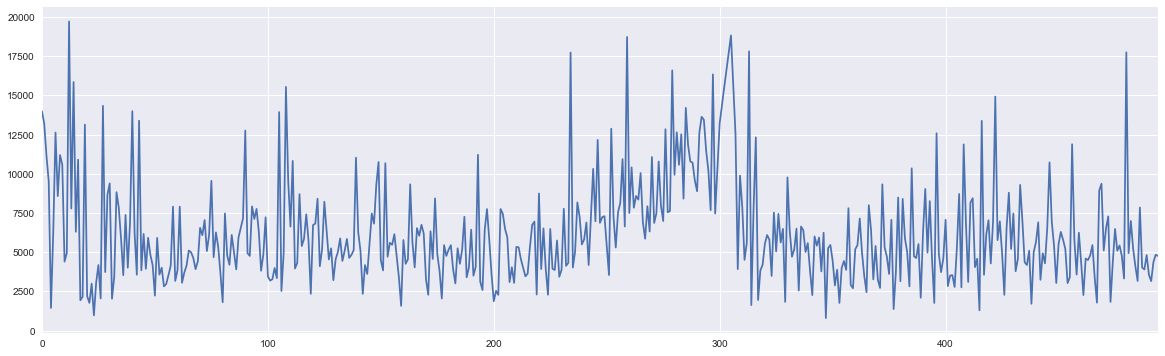

In [6]:
# checking stationarity of a time-series on a daily basis
ts_day = df_day['price']
ts_day.plot(figsize=(20, 6))

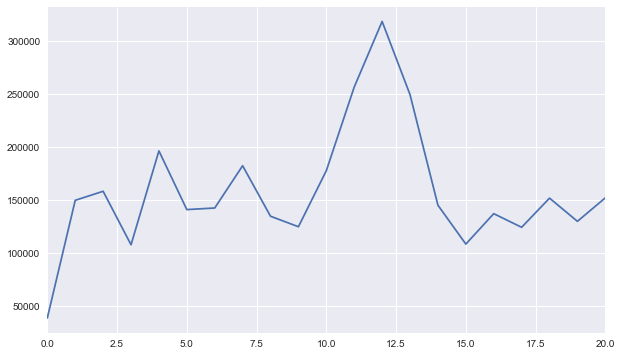

In [7]:
# checking stationarity of a time-series on a monthly basis
df_month = df_clean.groupby(['year', 'month']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
ts_month = df_month['price']
ts_month.plot(figsize=(10, 6))

#### Stationarity check of time series

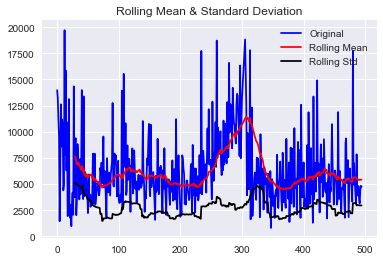

Results of Dickey-Fuller Test:
Test Statistic                  -3.500937
p-value                          0.007963
#Lags Used                      10.000000
Number of Observations Used    474.000000
Critical Value (1%)             -3.444221
Critical Value (5%)             -2.867657
Critical Value (10%)            -2.570028
dtype: float64


In [8]:
test_stationarity(ts_day)

##### Fitting ARIMA time series model to untransformed data

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



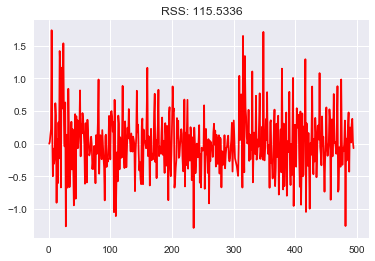

In [9]:
fit_ARIMA(ts_day, (1,1,1))

##### Decomposing the time series into trend, seasonality and residuals 

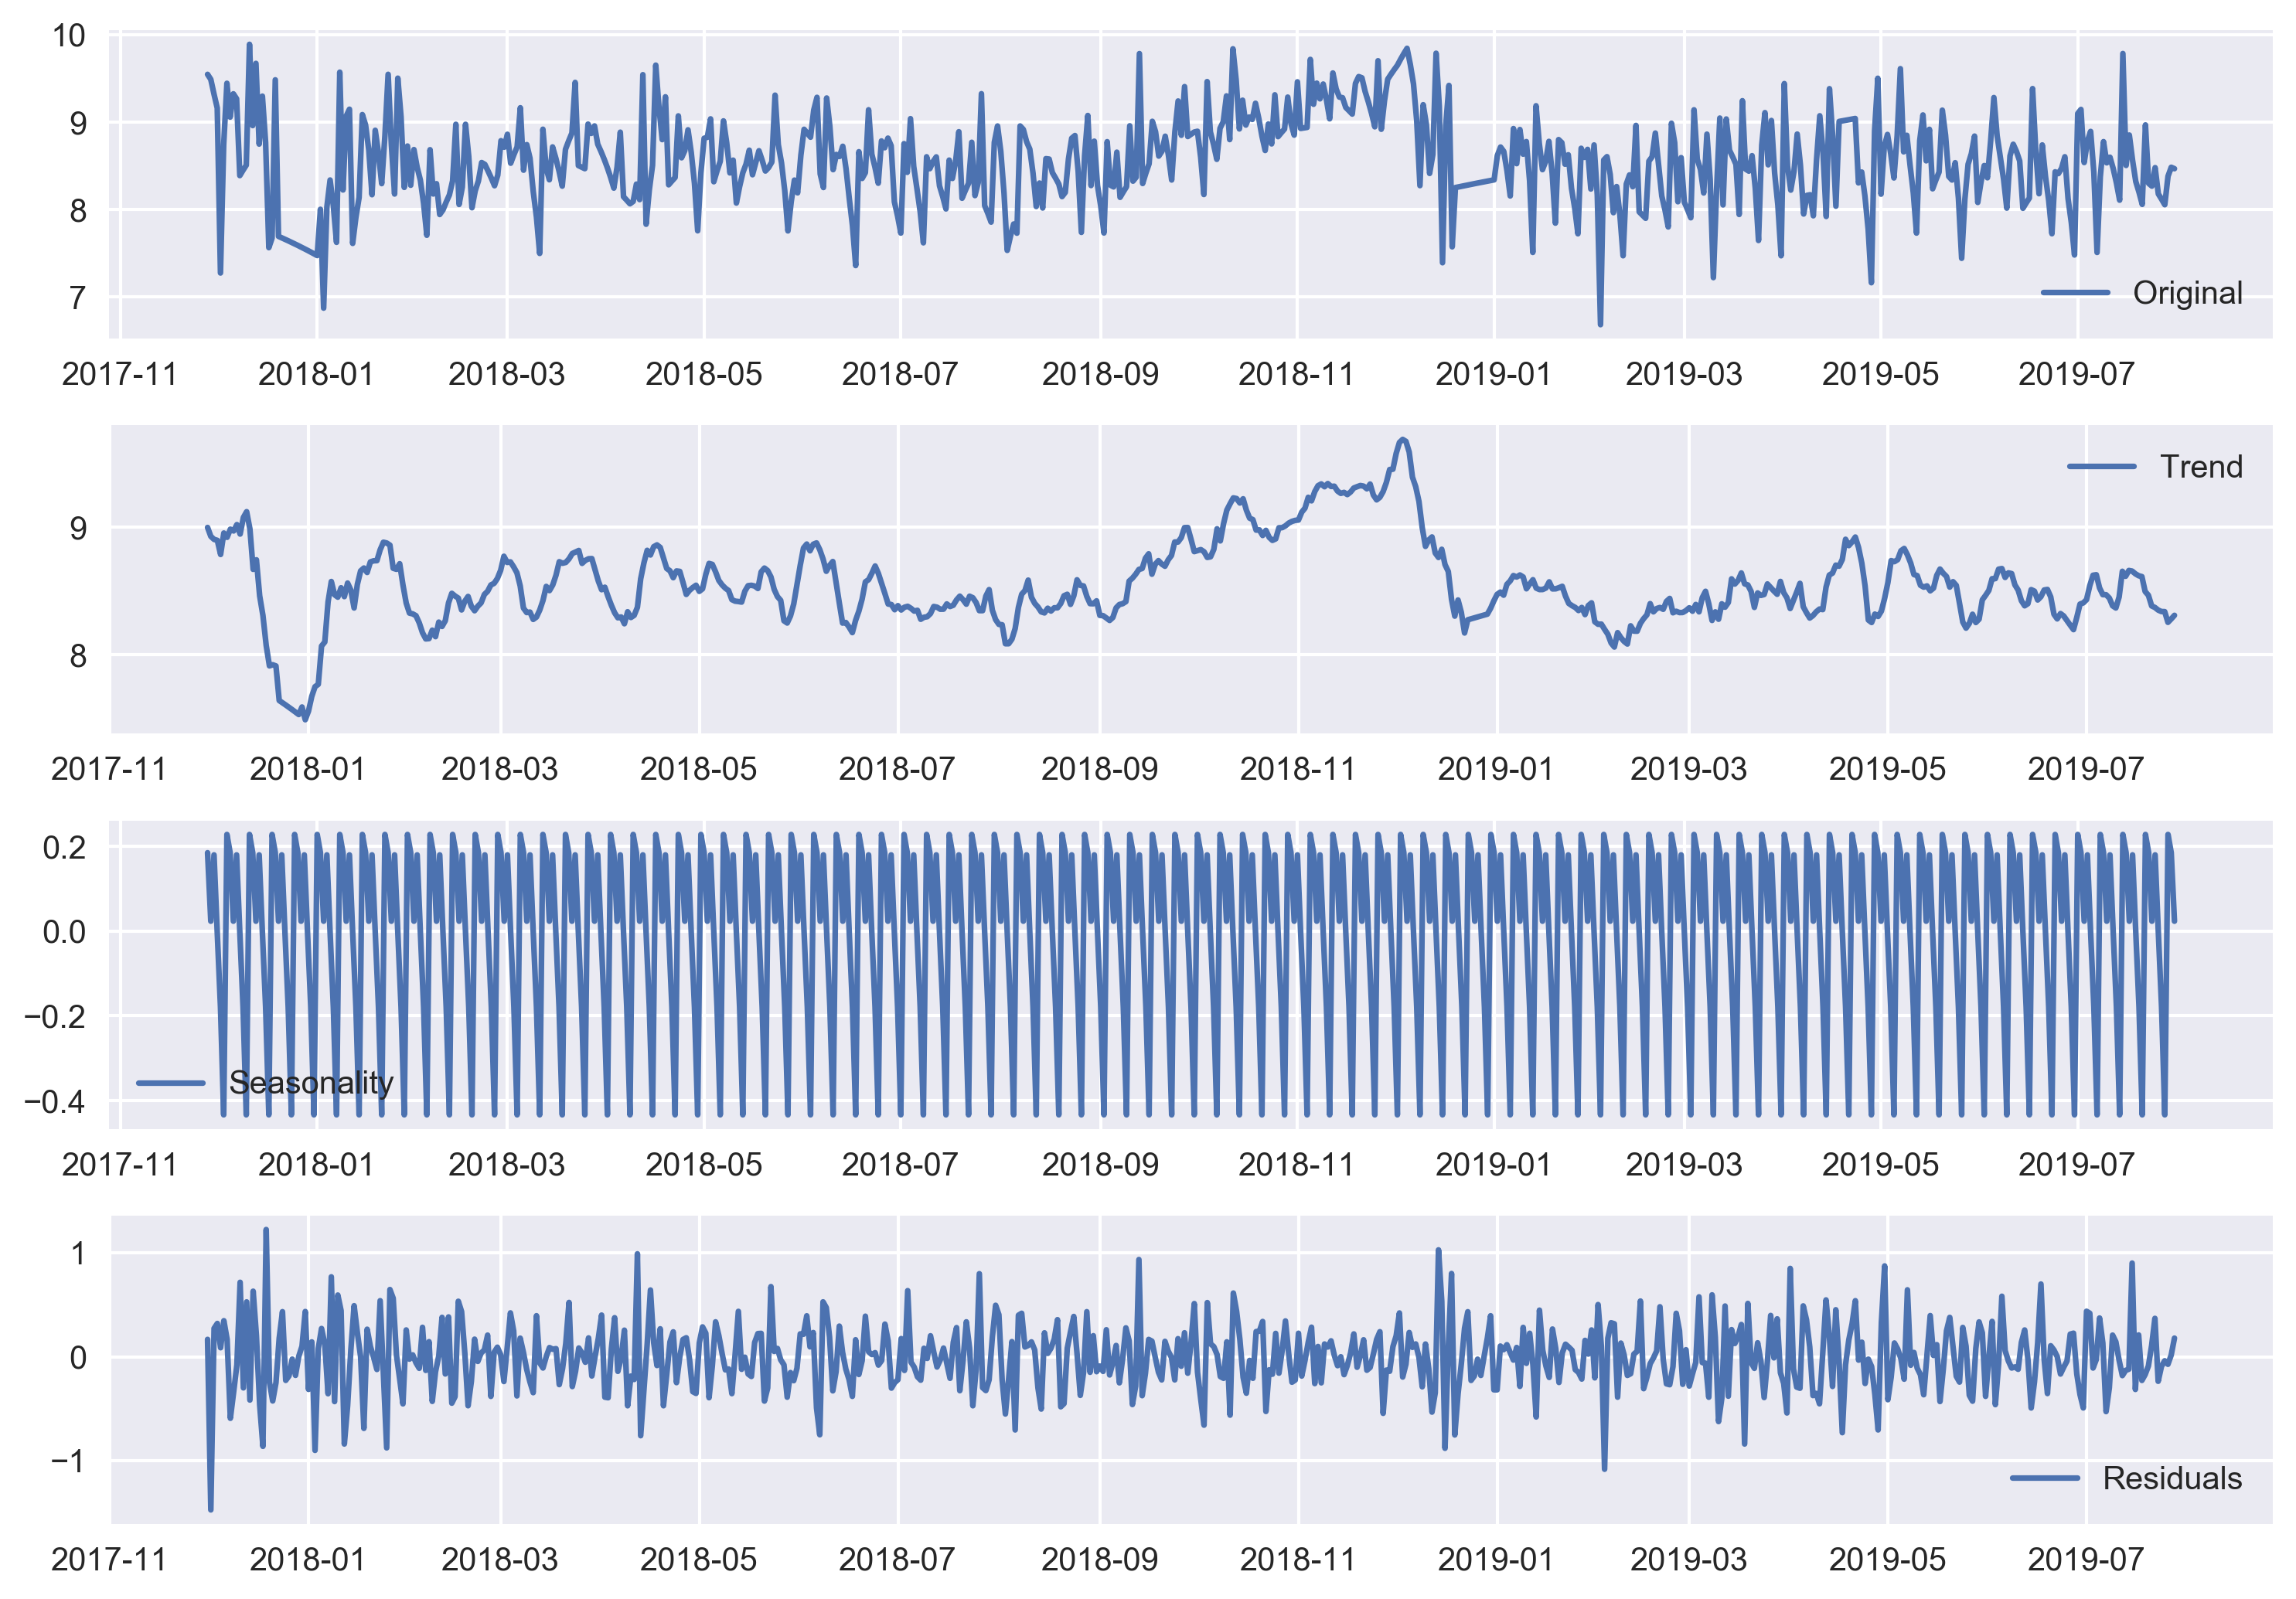

In [10]:
# Fill the missing datas to make data continuous and compatible with decompose function
ts = make_continuous(df_day)
## Decompose the data into trend, seasonality and residual
trend, seasonal, residual = decompose(ts, 'price')

##### Log transforming data and calculating ACF, PACF for ARIMA model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



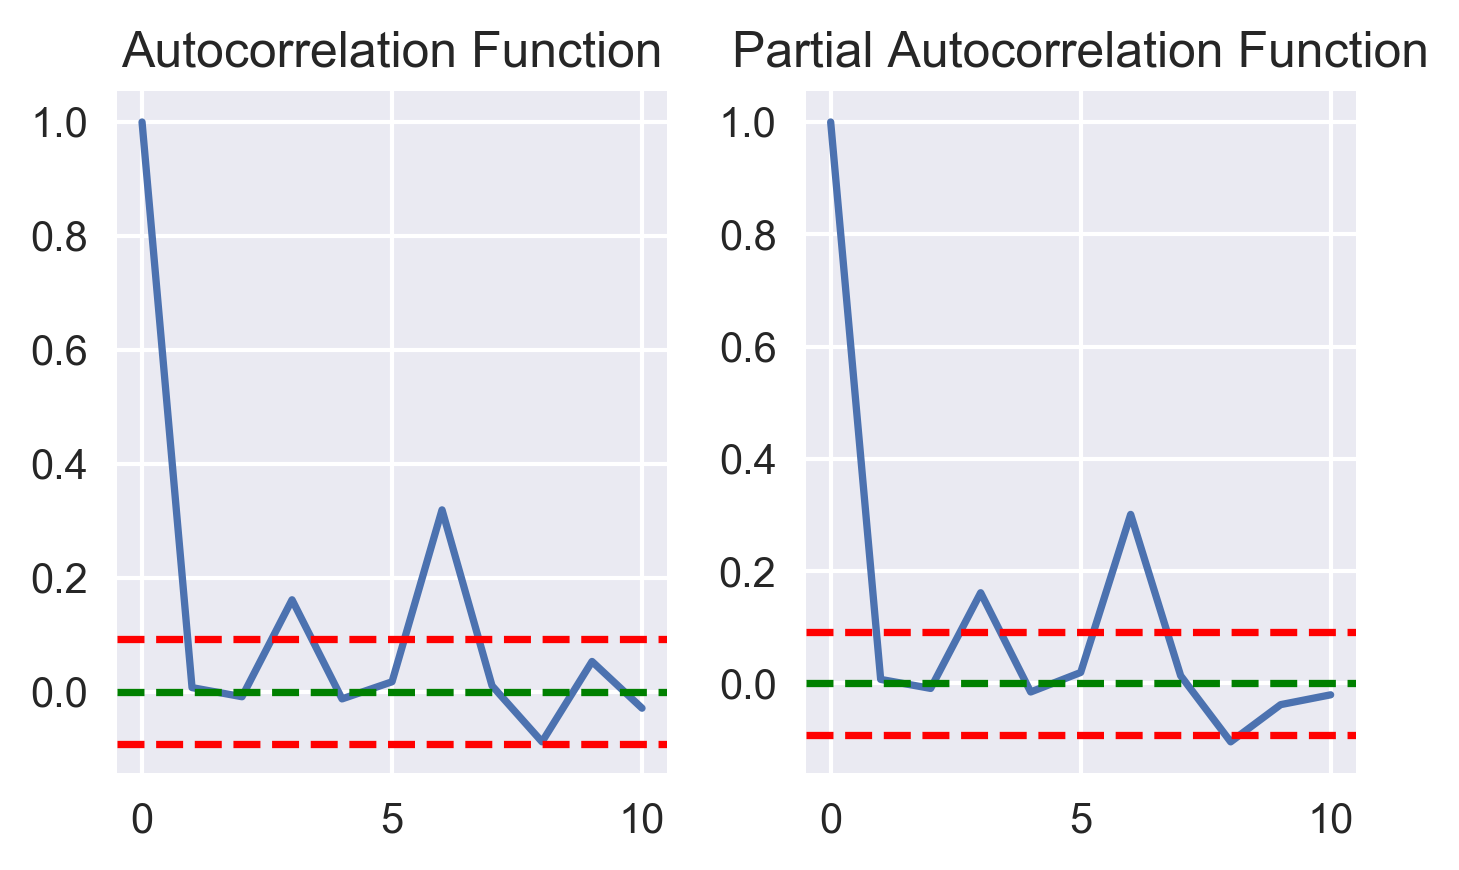

In [11]:
## Applying ACF and PACF 
ACF_PACF(ts_day)


##### Fitting ARIMA model to the log transformed data

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



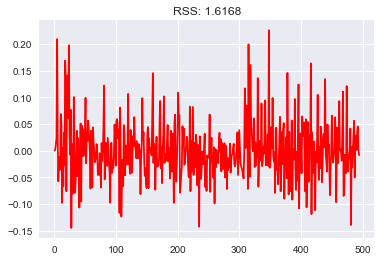

In [12]:
# ts_transformed = transform(ts_day, 30)
ts_transformed, ts_log_diff = log_shift(ts_day, 30)
fitted = fit_ARIMA(ts_transformed, (1,1,1))

It can be observed that log shifting by 30 days made the ARIMA much more accurate reducing the RSS to 1.8 from 137.4 

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



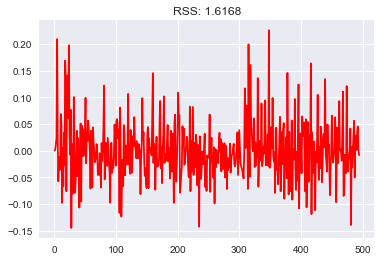

In [13]:
predictions = predict_ARIMA(ts_transformed, (1,1,1))

In [14]:
predictions.head()

1   -0.000118
2    0.002949
3    0.014319
4    0.023750
5    0.209206
dtype: float64

In [15]:
# ts_log, ts_log_diff = log_shift(ts, 1)
ts_transformed.head()

0    9.545359
1    9.488097
2    9.318791
3    9.160395
4    7.274660
Name: price, dtype: float64

In [16]:
predictions_ARIMA_diff_cumsum = predictions.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

1   -0.000118
2    0.002832
3    0.017151
4    0.040901
5    0.250107
dtype: float64


In [17]:
predictions_ARIMA_log = pd.Series(ts_transformed.ix[0], index=ts_transformed.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



0    9.545359
1    9.545242
2    9.548191
3    9.562510
4    9.586260
dtype: float64

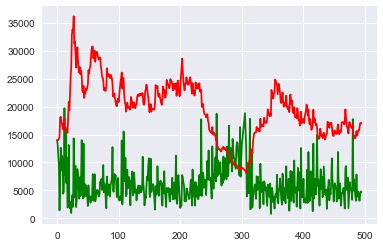

In [18]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_day, color='green')
plt.plot(predictions_ARIMA, color='red')


#### Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,8188.0,5871.0,12351.0,8188.0,8188.0,913.0,913.0,913.0,913.0,913.0,913.0,0.0,0.0,0.0,9100.0
1,2017-11-29,8106.0,4973.0,11307.0,8106.0,8106.0,35.0,35.0,35.0,35.0,35.0,35.0,0.0,0.0,0.0,8141.0
2,2017-11-30,8023.0,5715.0,12209.0,8023.0,8023.0,918.0,918.0,918.0,918.0,918.0,918.0,0.0,0.0,0.0,8942.0
3,2017-12-01,7941.0,4810.0,11124.0,7941.0,7941.0,-74.0,-74.0,-74.0,-74.0,-74.0,-74.0,0.0,0.0,0.0,7867.0
4,2017-12-02,7859.0,3625.0,9814.0,7859.0,7859.0,-1149.0,-1149.0,-1149.0,-1149.0,-1149.0,-1149.0,0.0,0.0,0.0,6710.0
5,2017-12-03,7777.0,2614.0,8951.0,7777.0,7777.0,-2076.0,-2076.0,-2076.0,-2076.0,-2076.0,-2076.0,0.0,0.0,0.0,5700.0
6,2017-12-04,7694.0,5671.0,12442.0,7694.0,7694.0,1433.0,1433.0,1433.0,1433.0,1433.0,1433.0,0.0,0.0,0.0,9128.0
7,2017-12-05,7612.0,5349.0,11585.0,7612.0,7612.0,913.0,913.0,913.0,913.0,913.0,913.0,0.0,0.0,0.0,8525.0
8,2017-12-06,7530.0,4138.0,10689.0,7530.0,7530.0,35.0,35.0,35.0,35.0,35.0,35.0,0.0,0.0,0.0,7565.0
9,2017-12-07,7448.0,5073.0,11498.0,7448.0,7448.0,918.0,918.0,918.0,918.0,918.0,918.0,0.0,0.0,0.0,8366.0


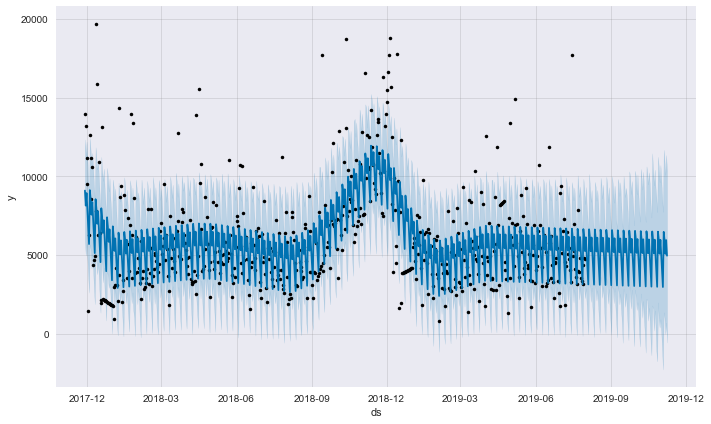

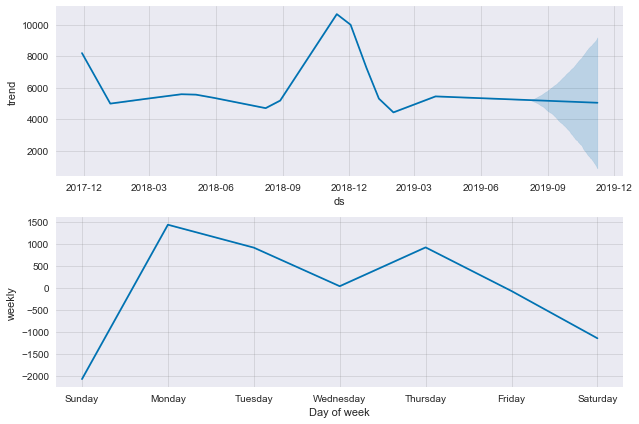

In [19]:
prophet_forecast(df_day, 100)

##### Forecasting using prophet

In [20]:
m = Prophet()
ts = make_continuous(df_day)
df = pd.DataFrame()
df['ds'] = ts.index
df['y'] = ts.price.values
m.fit(df)
future = m.make_future_dataframe(periods=30)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
636,2019-08-26
637,2019-08-27
638,2019-08-28
639,2019-08-29
640,2019-08-30


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
636,2019-08-26,5933.976203,2096.221972,9676.891687
637,2019-08-27,5432.236095,1737.022527,9279.554554
638,2019-08-28,4540.301157,621.893020,8459.180430
639,2019-08-29,5403.715836,1663.819767,9273.734771
640,2019-08-30,4396.981127,737.328807,8039.080931


#### Cross-validating fb prophet forecasting results

In [22]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='500 days', period='150 days', horizon = '100 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-04-22 00:00:00 and 2019-04-22 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-23,5681.844728,2024.930520,9322.473230,8439.160000,2019-04-22
1,2019-04-24,5028.151651,1147.511046,8569.565695,4042.310000,2019-04-22
2,2019-04-25,5948.941561,2329.158251,9977.242448,4575.920000,2019-04-22
3,2019-04-26,4999.374741,1312.779677,8846.601550,3480.966667,2019-04-22
4,2019-04-27,3852.402129,-95.290630,8176.784132,2386.013333,2019-04-22


In [23]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,10 days,8.147516e+06,2854.385356,2027.248235,0.432222,0.9
1,11 days,7.844951e+06,2800.884039,1965.459315,0.429974,0.9
2,12 days,8.112462e+06,2848.238359,2057.846019,0.439357,0.9
3,13 days,8.149976e+06,2854.816357,2070.887969,0.444493,0.9
4,14 days,7.990573e+06,2826.760167,2003.399350,0.413039,0.9


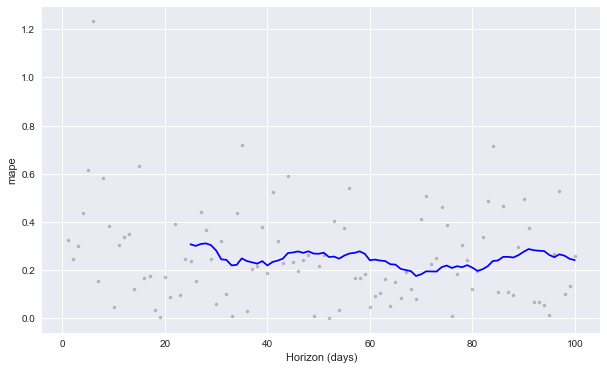

In [24]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.25)